<a href="https://colab.research.google.com/github/fuyan2/ML_research/blob/master/logistic0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[ -8.39488205   8.57472771]
 [  5.33967606  14.01741273]
 [ 10.47216807   7.70283687]
 ...
 [ -4.74595484  12.10272336]
 [ 16.96561006 -11.27635078]
 [ 10.10749142 -13.29955559]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]


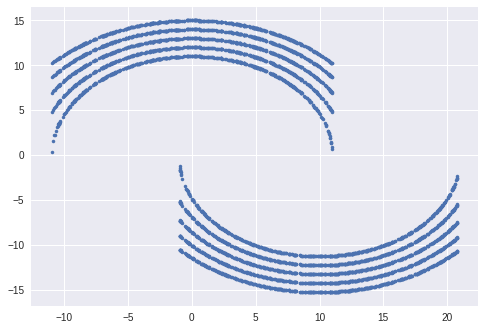

In [40]:
import time
import numpy as np
import sys
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pdb
import copy
import multiprocessing as mp

from datetime import datetime
from skimage.measure import compare_ssim

#Defining Parameters
IMG_ROWS = 28
IMG_COLS = 28
NUM_LABEL = 10
INV_HIDDEN = 5000
EPOCHS = 200
learning_rate = 0.1
BATCH_SIZE = 250

#Flatten input dataset
x1_0 = np.reshape(np.random.uniform(-11,11, 500), [500,-1])

x2_0 = np.sqrt(15**2 - x1_0**2) 
x3_0 = np.sqrt(14**2 - x1_0**2)
x4_0 = np.sqrt(13**2 - x1_0**2)
x5_0 = np.sqrt(12**2 - x1_0**2)
x6_0 = np.sqrt(11**2 - x1_0**2)

x_0_0 = np.concatenate((x1_0, x2_0), axis=1)
x_0_1 = np.concatenate((x1_0, x3_0), axis=1)
x_0_2 = np.concatenate((x1_0, x4_0), axis=1)
x_0_3 = np.concatenate((x1_0, x5_0), axis=1)
x_0_4 = np.concatenate((x1_0, x6_0), axis=1)


x1_1 = np.reshape(np.random.uniform(-1,21, 500), [500,-1])
x2_1 = - np.sqrt(15**2 - (x1_1 -10 )**2)-0.3
x3_1 = - np.sqrt(14**2 - (x1_1 -10 )**2)-0.3
x4_1 = - np.sqrt(13**2 - (x1_1 -10 )**2)-0.3
x5_1 = - np.sqrt(12**2 - (x1_1 -10 )**2)-0.3
x6_1 = - np.sqrt(11**2 - (x1_1 -10 )**2)-0.3

x_1_0 = np.concatenate((x1_1, x2_1), axis=1)
x_1_1 = np.concatenate((x1_1, x3_1), axis=1)
x_1_2 = np.concatenate((x1_1, x4_1), axis=1)
x_1_3 = np.concatenate((x1_1, x5_1), axis=1)
x_1_4 = np.concatenate((x1_1, x6_1), axis=1)

# print(x_1.shape)
x_train = np.concatenate((x_0_0,x_0_1,x_0_2, x_0_3, x_0_4, x_1_0, x_1_1, x_1_2, x_1_3, x_1_4), axis=0)
# print(x_train.shape)
# print(x_train)
y_0 = np.full((2500,1),0, dtype=np.int32)
y_1 = np.full((2500,1),1, dtype=np.int32)
y_train = np.concatenate((y_0,y_1), axis=0)
# print(y_train.shape)
# print(y_train)
# plt.plot(x_train[0:2500,0], x_train[0:2500,1],'.')
# plt.plot(x_train[2500:5000,0], x_train[2500:5000,1],'.')
train = np.concatenate((x_train,y_train),axis=1)
np.random.shuffle(train)
# print(train.shape)
# print(train)
plt.plot(train[:,0], train[:,1],'.')
x_train = train[:,[0,1]]
y_train = train[:,[2]]
print(x_train)
print(y_train)

In [41]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = np.reshape(x_train, [x_train.shape[0], -1])
x_test = np.reshape(x_test, [x_test.shape[0], -1])
y_train = np.reshape(y_train, [y_train.shape[0], -1])
y_test = np.reshape(y_test, [y_test.shape[0], -1])

#construct dataset
features = tf.placeholder(tf.float32, shape=[None, IMG_ROWS * IMG_COLS])
labels = tf.placeholder(tf.int32, shape=[None, 1])
batch_size = tf.placeholder(tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size).repeat()
iter = dataset.make_initializable_iterator()
x, y_ = iter.get_next()
y = tf.one_hot(tf.reshape(y_,[-1]), NUM_LABEL)

# print(x)
# print(y_)
# print(y)
# print(y_train)
# print(y_train.shape)
# print(x_train.shape)
# xavier_initializer = tf.contrib.layers.xavier_initializer()

def layer(input, num_units):
  W = tf.Variable(tf.zeros([input.shape[1], num_units], tf.float32), name="w")
  B = tf.Variable(tf.zeros([num_units], tf.float32), name="b")
  output = tf.matmul(input,W)+B
  return W, B, output

def lrelu(x, alpha):
  return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

def inverter(y, model_weights):
  # Input layer
  ww = tf.matmul(model_weights, inv_weights['w_model'])
  wy = tf.matmul(y, inv_weights['w_label'])
  wt = tf.add(wy, ww)
  hidden_layer =  tf.add(wt, inv_weights['b_in'])
  rect = lrelu(hidden_layer, 0.3)
  # Output Layer
  out_layer = tf.add(tf.matmul(rect, inv_weights['w_out']), inv_weights['b_out'])
  rect = lrelu(out_layer, 0.3)
  return tf.tanh(rect)

#Build Logistic Layer
with tf.name_scope("logistic_layer"):
#   w,b,z = layer(x,NUM_LABEL)
  w = tf.Variable(tf.zeros([x.shape[1], NUM_LABEL], tf.float32), name="w")
  b = tf.Variable(tf.zeros([NUM_LABEL], tf.float32), name="b")
  y_ml = tf.nn.softmax(tf.matmul(x,w)+b)

#Build Inverter Regularizer
model_weights = tf.concat([tf.reshape(w,[1, -1]),tf.reshape(b,[1, -1])], 1)
# print(model_weights)
inv_weights = {
  'w_model': tf.Variable(tf.zeros([tf.reshape(model_weights, [-1]).shape[0], INV_HIDDEN])),
  'w_label': tf.Variable(tf.zeros([NUM_LABEL, INV_HIDDEN])),
  'w_out': tf.Variable(tf.zeros([INV_HIDDEN, IMG_ROWS * IMG_COLS])),
  'b_in': tf.Variable(tf.zeros([INV_HIDDEN])),
  'b_out': tf.Variable(tf.zeros([IMG_ROWS * IMG_COLS]))
}

inv_x = inverter(y, model_weights)
# print(inv_x)
# Calculate loss
class_loss = tf.losses.softmax_cross_entropy(y,y_ml)
inv_loss = tf.losses.mean_squared_error(labels=x, predictions=inv_x)
# calculate prediction accuracy
correct = tf.equal(tf.argmax(y_ml, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

def train(loss_beta, learning_rate, Epoch):
  total_loss = class_loss - loss_beta * inv_loss
  model_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss, var_list=[w,b])
  inverter_optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(inv_loss, var_list=[inv_weights])
  init_vars = tf.global_variables_initializer()
  
  with tf.Session() as sess:
    sess.run(init_vars)
   
    # initialise iterator with train data
    sess.run(iter.initializer, feed_dict = {features: x_train, labels: y_train, batch_size: 250})
    
    print('Training...')
    for i in range(Epoch):
      sess.run(model_optimizer)
      sess.run(inverter_optimizer)
      train_acc = sess.run(accuracy)
      train_total_loss = sess.run(total_loss)
      train_inv_loss = sess.run(inv_loss)
      train_class_loss = sess.run(class_loss)
      print("step %g train accuracy is %g, total_loss is %g, inv_loss is %g, class_loss is %g"%(i, train_acc,train_total_loss, train_inv_loss, train_class_loss))
    # initialise iterator with test data
#     sess.run(iter.initializer, feed_dict = {features: x_train, labels: y_train, batch_size: y_train.shape[0]})
    sess.run(iter.initializer, feed_dict = {features: x_test, labels: y_test, batch_size: y_test.shape[0]})
    test_acc = sess.run(accuracy)
    print("beta is %g, test accuracy is %g"%(beta, test_acc))
      
    return test_acc

betas = [0.0, 0.001, 0.01, 0.1, 0.5, 1., 2., 5., 7., 10., 15., 20.]
test_accs = np.zeros(len(betas))
# Setup a list of processes that we want to run
# pool = mp.Pool(processes=len(betas))
# results = [pool.apply(train, args=(beta, 0.01, 200)) for beta in betas]
# print(results)
for i,beta in enumerate(betas):
  test_accs[i] = train(beta,0.01,200)

np.save("logreg_acc", test_accs)
plt.plot(betas, test_accs)

Training...
step 0 train accuracy is 0.456, total_loss is 2.03986, inv_loss is 6940.06, class_loss is 2.02891
step 1 train accuracy is 0.644, total_loss is 1.84723, inv_loss is 7460.22, class_loss is 1.83367
step 2 train accuracy is 0.604, total_loss is 1.8592, inv_loss is 7189.29, class_loss is 1.86305
step 3 train accuracy is 0.48, total_loss is 2.03775, inv_loss is 7642.83, class_loss is 1.96985
step 4 train accuracy is 0.588, total_loss is 2.00645, inv_loss is 6475.77, class_loss is 2.01436
step 5 train accuracy is 0.576, total_loss is 1.94071, inv_loss is 8591.91, class_loss is 1.86913
step 6 train accuracy is 0.584, total_loss is 1.8343, inv_loss is 7885.59, class_loss is 1.86179
step 7 train accuracy is 0.616, total_loss is 1.85884, inv_loss is 7153.93, class_loss is 1.87765
step 8 train accuracy is 0.58, total_loss is 1.91636, inv_loss is 8427.17, class_loss is 1.91599
step 9 train accuracy is 0.52, total_loss is 1.85265, inv_loss is 6947.24, class_loss is 1.94477
step 10 train

KeyboardInterrupt: ignored